In [50]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from ISLP.models import sklearn_sm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns
import itertools
from pygam import LinearGAM, s, f, l
sns.set_palette("pastel")

In [31]:
College = load_data("college")
X = College.drop('Outstate', axis=1)
y = College['Outstate']

In [32]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
sns.pairplot(College)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
selector = SequentialFeatureSelector(RidgeCV(),cv=10).fit(X_train,y_train)

In [48]:
X_train_selected = X_train.loc[:,selector.get_support()]
X_test_selected = X_test.loc[:,selector.get_support()]

In [49]:
X_train_selected

,Top25perc,Room.Board,PhD,Terminal,perc.alumni,Expend,Grad.Rate,Private_Yes
83,34,5340,90,92,26,7972,64,True
61,45,3352,81,89,14,6918,67,False
275,48,3782,49,51,15,6562,34,True
426,37,4900,44,47,26,4948,33,True
182,48,3800,46,65,29,10188,82,True
...,...,...,...,...,...,...,...,...
71,95,6750,100,100,49,17449,89,True
106,82,4270,95,99,60,13118,74,True
270,86,4090,77,92,34,9605,83,True
435,44,3150,58,64,8,6578,45,True


In [90]:
gam = LinearGAM(l(0) + l(1) + s(2) + s(3) + l(4) + s(5) + l(6) + f(7)).fit(X_train_selected, y_train)

In [113]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     35.1908
Link Function:                     IdentityLink Log Likelihood:                                 -8277.0706
Number of Samples:                          520 AIC:                                            16626.5228
                                                AICc:                                           16632.0983
                                                GCV:                                          3713581.9216
                                                Scale:                                        3264132.8545
                                                Pseudo R-Squared:                                   0.8146
Feature Function                  Lam

C:\Users\basti\AppData\Local\Temp\ipykernel_19984\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


<Figure size 640x480 with 0 Axes>

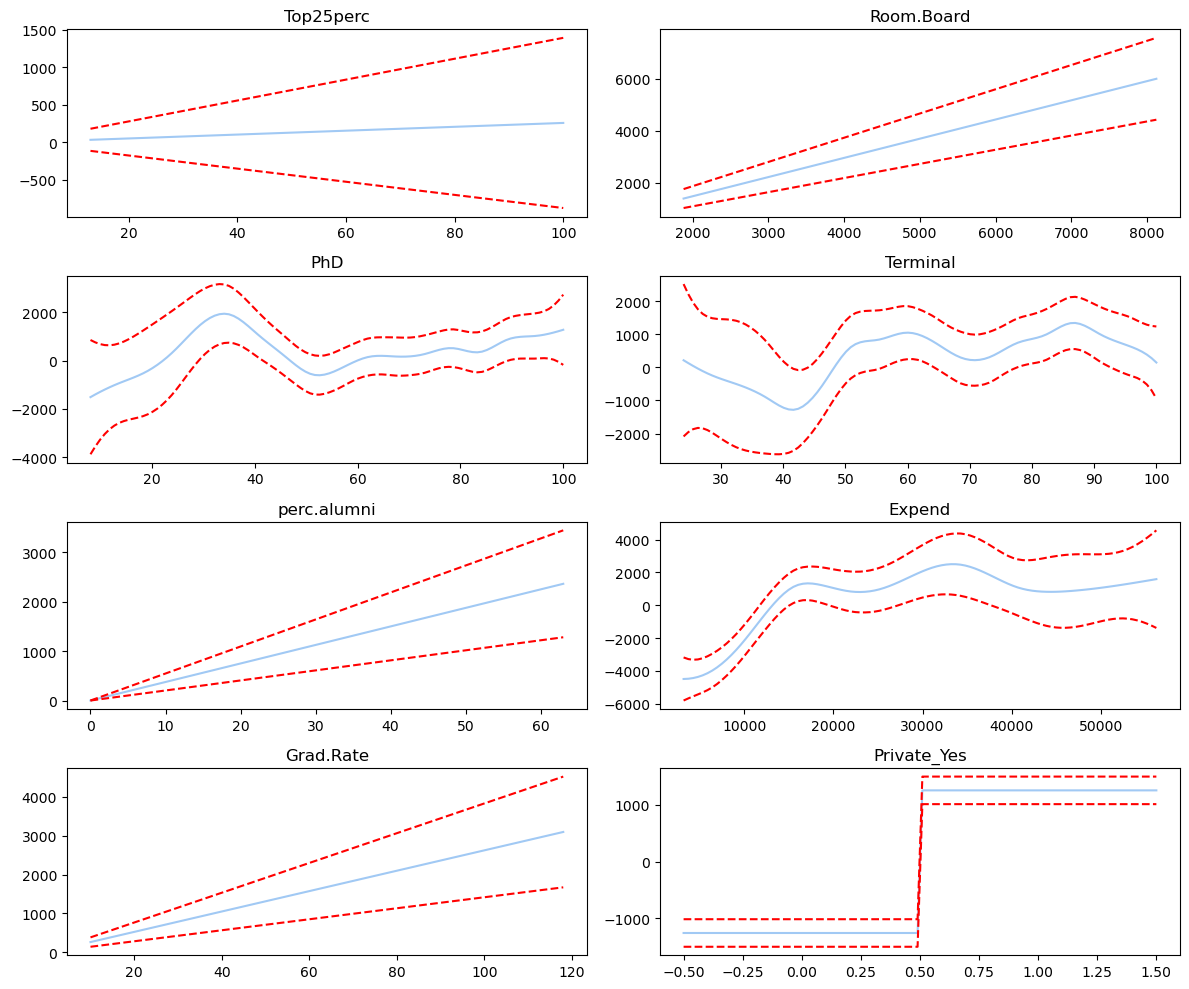

In [91]:
## plotting
plt.figure();
fig, axs = plt.subplots(4, 2, figsize=(12, 10))   # 3×3 grid
axs = axs.ravel()                                 # flatten to 1-D array

titles = list(X_train_selected.columns)
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
plt.tight_layout()

In [111]:
# Let's tune the parameters

lams = np.random.rand(1000, 8) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3
gam_opt = LinearGAM(l(0) + l(1) + s(2) + s(3) + l(4) + s(5) + l(6) + f(7)).gridsearch(X_train_selected.to_numpy(), y_train, lam=lams)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:260002


In [112]:
gam_opt.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.6151
Link Function:                     IdentityLink Log Likelihood:                                 -8286.6401
Number of Samples:                          520 AIC:                                            16612.5105
                                                AICc:                                             16614.13
                                                GCV:                                          3552943.1649
                                                Scale:                                        3324757.5227
                                                Pseudo R-Squared:                                   0.8047
Feature Function                  Lam

C:\Users\basti\AppData\Local\Temp\ipykernel_19984\183087434.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_opt.summary()


<Figure size 640x480 with 0 Axes>

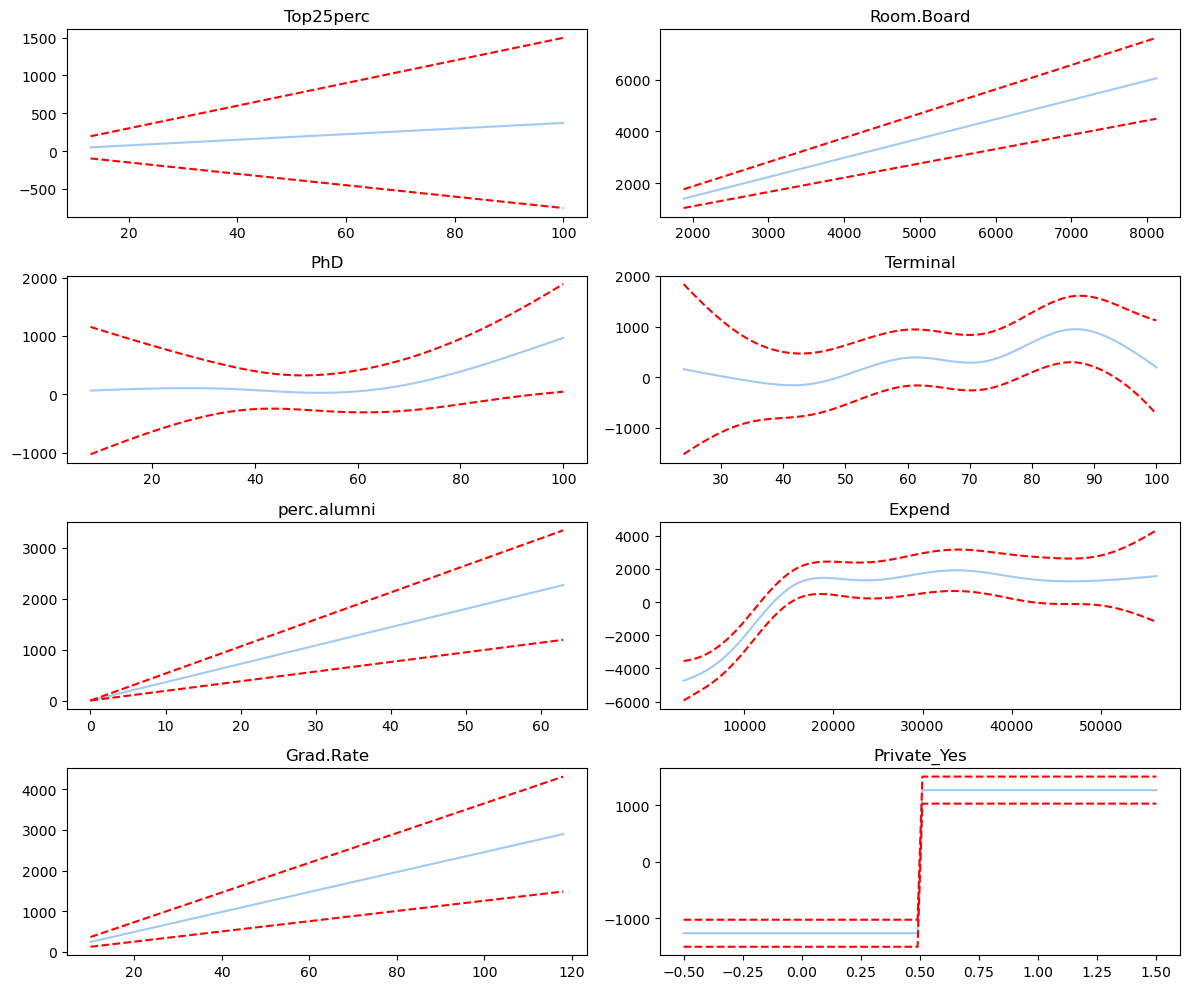

In [117]:
## plotting
plt.figure();
fig, axs = plt.subplots(4, 2, figsize=(12, 10))   # 3×3 grid
axs = axs.ravel()                                 # flatten to 1-D array

titles = list(X_train_selected.columns)
for i, ax in enumerate(axs):
    XX = gam_opt.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_opt.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_opt.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
plt.tight_layout()

<Axes: ylabel='Outstate'>

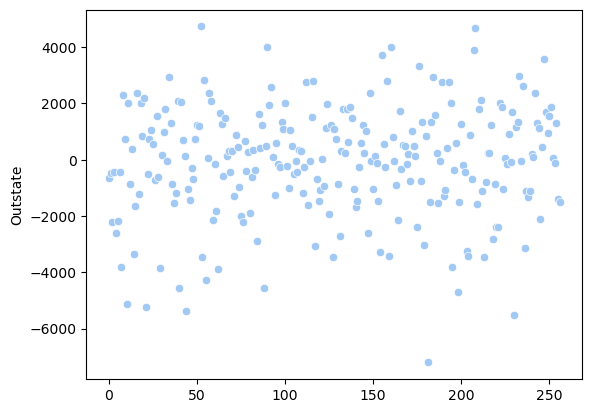

In [124]:
y_pred = gam_opt.predict(X_test_selected)
residual = y_test - y_pred
sns.scatterplot(y = residual, x = range(len(residual)))

In [126]:
mean_squared_error(y_test, y_pred)

3845216.2109680786

In [132]:
# Let's tune the parameters

lams = np.random.rand(1000, 8) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3
gam_opt = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + f(7)).gridsearch(X_train_selected.to_numpy(), y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


<Figure size 640x480 with 0 Axes>

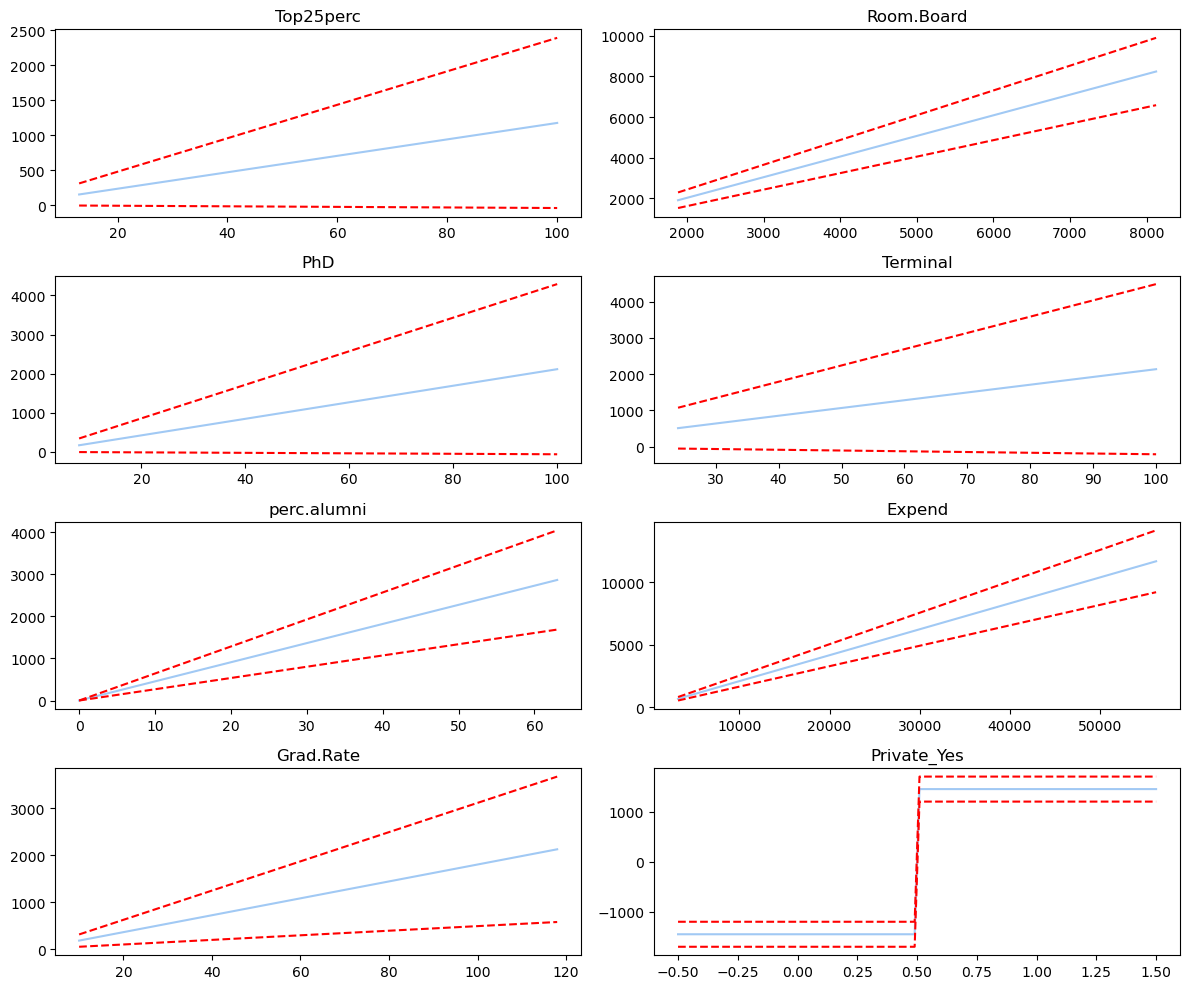

In [133]:
## plotting
plt.figure();
fig, axs = plt.subplots(4, 2, figsize=(12, 10))   # 3×3 grid
axs = axs.ravel()                                 # flatten to 1-D array

titles = list(X_train_selected.columns)
for i, ax in enumerate(axs):
    XX = gam_opt.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_opt.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_opt.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
plt.tight_layout()

<Axes: ylabel='Outstate'>

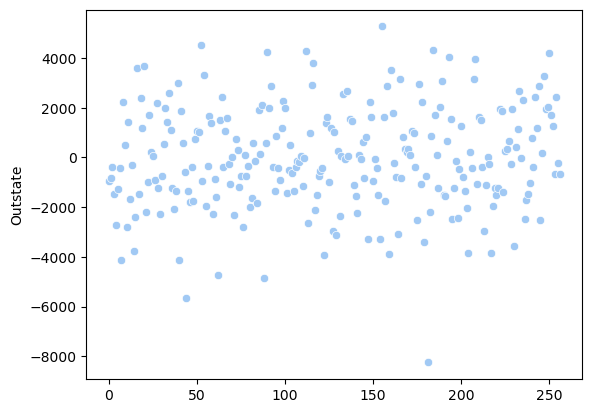

In [134]:
y_pred = gam_opt.predict(X_test_selected)
residual = y_test - y_pred
sns.scatterplot(y = residual, x = range(len(residual)))

In [135]:
mean_squared_error(y_test, y_pred)

4161845.845043379